In [1]:
import pandas as pd
import os  # For file path handling
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline
pd.set_option('display.max_columns', 200)  # Set maximum number of columns to display
pd.set_option('display.width', 120) # Set display width for better readability


In [2]:
# load data
file = "pakistan_weather_2000_2024.csv"
df = pd.read_csv(file, parse_dates=["date"], dayfirst=True, low_memory=False)

# Display the first few rows of the DataFrame
print("Rows,cols:", df.shape)
display(df.head())

Rows,cols: (31779, 27)


,date,year,month,day,dayofweek,is_weekend,season,city,region,latitude,longitude,elevation,tmin,tmax,tavg,prcp,wspd,humidity,pressure,dew_point,cloud_cover,visibility,temp_range,is_hot_day,is_cold_day,rainfall_intensity,wind_category
0,1/1/2000,2000,1,1,5,1,Winter,Islamabad,Punjab,33.6844,73.0479,540,3.1,17.2,9.4,0.0,6.0,76,1018.9,4.8,0,NaN,14.1,0,0,none,windy
1,1/2/2000,2000,1,2,6,1,Winter,Islamabad,Punjab,33.6844,73.0479,540,2.9,17.4,9.3,0.0,6.1,77,1018.6,4.8,0,NaN,14.5,0,0,none,windy
2,1/3/2000,2000,1,3,0,0,Winter,Islamabad,Punjab,33.6844,73.0479,540,3.1,17.7,9.6,0.0,6.2,76,1016.8,5.0,0,NaN,14.6,0,0,none,windy
3,1/4/2000,2000,1,4,1,0,Winter,Islamabad,Punjab,33.6844,73.0479,540,3.4,17.6,9.6,0.0,5.9,75,1016.2,4.8,0,NaN,14.2,0,0,none,windy
4,1/5/2000,2000,1,5,2,0,Winter,Islamabad,Punjab,33.6844,73.0479,540,3.2,17.5,9.6,0.0,8.0,77,1017.5,5.3,0,NaN,14.3,0,0,none,windy


#### Understanding the Dataset: Structure, Data Types & Missing Values

Before analyzing or visualizing, it’s important to **understand the structure** of the dataset.

- `df.info()` shows the number of rows, data types of each column, and whether any missing values exist.  
- `df.describe()` gives summary statistics (like min, max, mean) for both numeric and categorical columns.  
- `df.isnull().sum()` counts missing values in each column.

**Why this matters:**  
This step helps identify:
1. Columns that need conversion (e.g., numbers mistakenly stored as text).  
2. Columns with missing data that we may need to fill or drop.  
3. Whether the dataset size and time coverage match our expectations (daily records from 2020–2024).  


In [3]:
#types and missing values
display(df.info())  #column types

display(df.describe(include="all").T)
 #stats
display(df.isnull().sum().sort_values(ascending=False).head(20))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31779 entries, 0 to 31778
Data columns (total 27 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   date                31779 non-null  object 
 1   year                31779 non-null  int64  
 2   month               31779 non-null  int64  
 3   day                 31779 non-null  int64  
 4   dayofweek           31779 non-null  int64  
 5   is_weekend          31779 non-null  int64  
 6   season              31779 non-null  object 
 7   city                31779 non-null  object 
 8   region              31779 non-null  object 
 9   latitude            31779 non-null  float64
 10  longitude           31779 non-null  float64
 11  elevation           31779 non-null  int64  
 12  tmin                31779 non-null  float64
 13  tmax                31779 non-null  float64
 14  tavg                31779 non-null  float64
 15  prcp                31779 non-null  float64
 16  wspd

None

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
date,31779,9132,1/1/2000,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN
year,31779.0,NaN,NaN,NaN,2011.10337,7.176794,2000.0,2005.0,2010.0,2017.0,2024.0
month,31779.0,NaN,NaN,NaN,6.522609,3.448845,1.0,4.0,7.0,10.0,12.0
day,31779.0,NaN,NaN,NaN,15.730577,8.800627,1.0,8.0,16.0,23.0,31.0
dayofweek,31779.0,NaN,NaN,NaN,3.000063,2.000267,0.0,1.0,3.0,5.0,6.0
is_weekend,31779.0,NaN,NaN,NaN,0.285818,0.45181,0.0,0.0,0.0,1.0,1.0
season,31779,4,Spring,8004,NaN,NaN,NaN,NaN,NaN,NaN,NaN
city,31779,6,Islamabad,9132,NaN,NaN,NaN,NaN,NaN,NaN,NaN
region,31779,5,Punjab,12420,NaN,NaN,NaN,NaN,NaN,NaN,NaN
latitude,31779.0,NaN,NaN,NaN,31.759637,3.653211,24.8607,30.1798,33.6844,34.0151,35.9221


visibility    31779
year              0
date              0
day               0
dayofweek         0
is_weekend        0
season            0
city              0
region            0
latitude          0
month             0
longitude         0
elevation         0
tmax              0
tmin              0
prcp              0
wspd              0
humidity          0
tavg              0
pressure          0
dtype: int64

#### Data Cleaning: Converting Columns to Correct Types

In raw datasets, numeric columns (like `tavg`, `prcp`, or `humidity`) sometimes contain errors (e.g., text values) that prevent proper analysis.

- **force conversion** of numeric columns to the correct type (`float` or `int`).  
- Any invalid values automatically become `NaN` (missing), which will be handled later.  
- The `date` column is explicitly converted to a `datetime` object and sorted.  

 **Why this matters:**  
- Ensures calculations (like averages, sums, correlations) work correctly.  
- Puts all records in chronological order, making time-series analysis possible.  
- Prepares the dataset for **feature engineering** and plotting.  


In [4]:
# Cell 4: coerce numeric columns (adjust list if you have different names)
num_cols = ['latitude','longitude','elevation','tmin','tmax','tavg','prcp',
            'wspd','humidity','pressure','dew_point','cloud_cover','visibility','temp_range','rainfall_intensity']
for c in num_cols:
    if c in df.columns:
        df[c] = pd.to_numeric(df[c], errors='coerce')

# ensure date is datetime and set index (optional)
df['date'] = pd.to_datetime(df['date'], errors='coerce')
df = df.sort_values('date').reset_index(drop=True)

# quick recheck
display(df[num_cols].info())
display(df[num_cols].isnull().sum().sort_values(ascending=False).head(10))


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31779 entries, 0 to 31778
Data columns (total 15 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   latitude            31779 non-null  float64
 1   longitude           31779 non-null  float64
 2   elevation           31779 non-null  int64  
 3   tmin                31779 non-null  float64
 4   tmax                31779 non-null  float64
 5   tavg                31779 non-null  float64
 6   prcp                31779 non-null  float64
 7   wspd                31779 non-null  float64
 8   humidity            31779 non-null  int64  
 9   pressure            31779 non-null  float64
 10  dew_point           31779 non-null  float64
 11  cloud_cover         31779 non-null  int64  
 12  visibility          0 non-null      float64
 13  temp_range          31779 non-null  float64
 14  rainfall_intensity  0 non-null      float64
dtypes: float64(12), int64(3)
memory usage: 3.6 MB


None

rainfall_intensity    31779
visibility            31779
latitude                  0
tmin                      0
tmax                      0
longitude                 0
elevation                 0
prcp                      0
tavg                      0
wspd                      0
dtype: int64

#### Step 5 — Feature Engineering: Adding Useful Date Features

The dataset has a `date` column, but additional **time-based features** can be extracted:
- `year` → to group by year.  
- `month` → to study seasonal/monthly patterns.  
- `day` → for daily granularity.  
- `dayofweek` → to see if weekdays vs weekends matter.  
- `is_weekend` → boolean flag for Saturday & Sunday.  

**Why this matters:**  
These derived features will help us:
- Compare weather **seasonally** (e.g., hottest month across years).  
- Study trends over **years** (e.g., warming or rainfall changes).  
- Identify differences between **weekdays vs weekends** (useful for human impact studies, air quality, etc.).  

This step is called **feature engineering** and is the foundation of most data science projects.  


In [5]:
# Cell 5: datetime features
df['year'] = df['date'].dt.year
df['month'] = df['date'].dt.month
df['day'] = df['date'].dt.day
df['dayofweek'] = df['date'].dt.dayofweek  # 0=Mon
df['is_weekend'] = df['dayofweek'].isin([5,6])
display(df[['date','year','month','day','dayofweek','is_weekend']].head())

,date,year,month,day,dayofweek,is_weekend
0,2000-01-01,2000,1,1,5,True
1,2000-01-01,2000,1,1,5,True
2,2000-01-01,2000,1,1,5,True
3,2000-01-01,2000,1,1,5,True
4,2000-01-02,2000,1,2,6,True


#### Exploratory Data Analysis (EDA)

Now that the dataset is cleaned and enriched with new features, the next step is **Exploratory Data Analysis (EDA)**.

EDA helps us:
- Understand overall trends in the data.
- Detect seasonality (e.g., hottest/coolest months, rainfall cycles).
- Compare patterns across cities and regions.
- Identify unusual data points (outliers).

**summary statistics** and **visualizations** will be used to uncover patterns.


#### Visualization A — Daily Temperature Trend

Plotting the **average daily temperature (`tavg`)** over time.

- A **rolling average (7-day)** smooths short-term noise and highlights seasonal cycles.
- This allows us to see yearly trends (summer vs winter) and whether there are long-term changes from 2020 to 2024.

**What to look for:**
- Do we see clear summer peaks and winter dips each year?
- Any unusual spikes/drops that may indicate anomalies or extreme events?


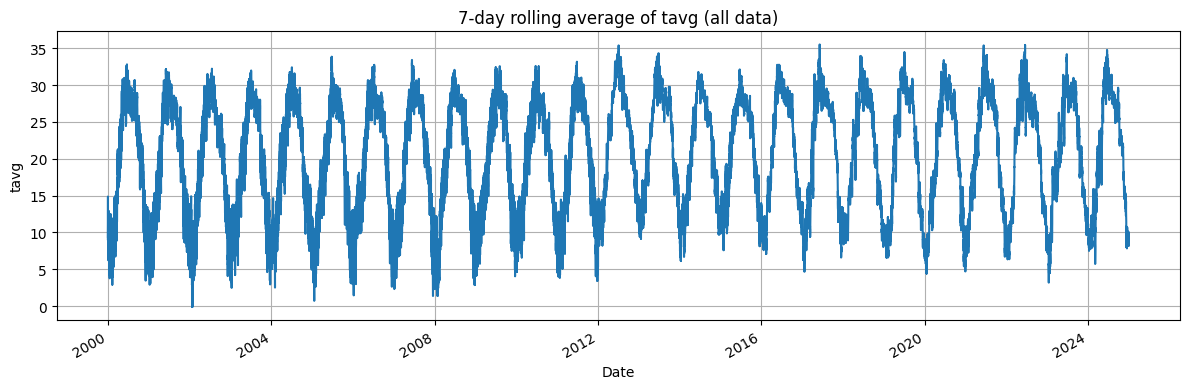

In [6]:
# Average temperature over time (single line)
plt.figure(figsize=(12,4))
df.set_index('date')['tavg'].rolling(7, min_periods=1).mean().plot()
plt.title('7-day rolling average of tavg (all data)')
plt.xlabel('Date')
plt.ylabel('tavg')
plt.grid(True)
plt.tight_layout()
plt.show()

#### Visualization B — Monthly Average Temperature (Seasonality)

By grouping all years together, we calculate the **average temperature per month**.

- This shows the **climatological cycle** of Pakistan.
- It helps identify the hottest months (e.g., May–June) and coolest months (e.g., January).

**Why it is important:**
Seasonal analysis is crucial for climate studies, agriculture, and energy planning.  
It also validates whether the dataset matches expected climate patterns.


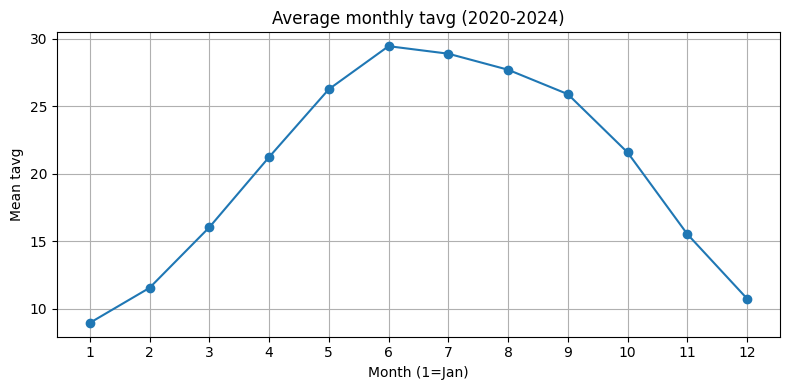

In [7]:
# Monthly average tavg (aggregated across all years)
monthly = df.groupby('month')['tavg'].mean()
plt.figure(figsize=(8,4))
monthly.plot(marker='o')
plt.title('Average monthly tavg (2020-2024)')
plt.xlabel('Month (1=Jan)')
plt.ylabel('Mean tavg')
plt.xticks(range(1,13))
plt.grid(True)
plt.tight_layout()
plt.show()


### Visualization C — Comparing Temperature Distributions by City

Using boxplots of `tavg` for different cities:

- Each box shows the **median, spread, and outliers** of daily average temperatures.
- Cities with higher elevation (e.g., northern areas) should have cooler distributions.
- Cities in the plains or coastal regions may show hotter, more humid profiles.

**Importance:**
This allows us to compare **regional climate variations** across Pakistan.


<Figure size 1200x600 with 0 Axes>

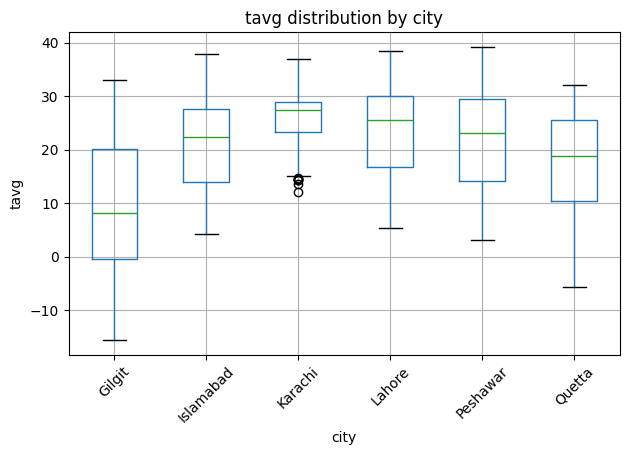

In [8]:
# Boxplot of tavg by city (only cities with enough samples)
city_counts = df['city'].value_counts()
good_cities = city_counts[city_counts > 200].index.tolist()  # adjust threshold
subset = df[df['city'].isin(good_cities)]

plt.figure(figsize=(12,6))
subset.boxplot(column='tavg', by='city', rot=45)
plt.title('tavg distribution by city')
plt.suptitle('')
plt.ylabel('tavg')
plt.tight_layout()
plt.show()


#### Visualization D — Rainfall Heatmap (Month vs Year)

Aggregate rainfall (`prcp`) by **month and year** and display as a heatmap.

- Darker colors = more rainfall.
- Monsoon months (July–September) are expected to have the highest rainfall totals.

**What to learn:**
- Which years had stronger/weaker monsoons?
- Are there shifts in rainfall timing or intensity across the years?


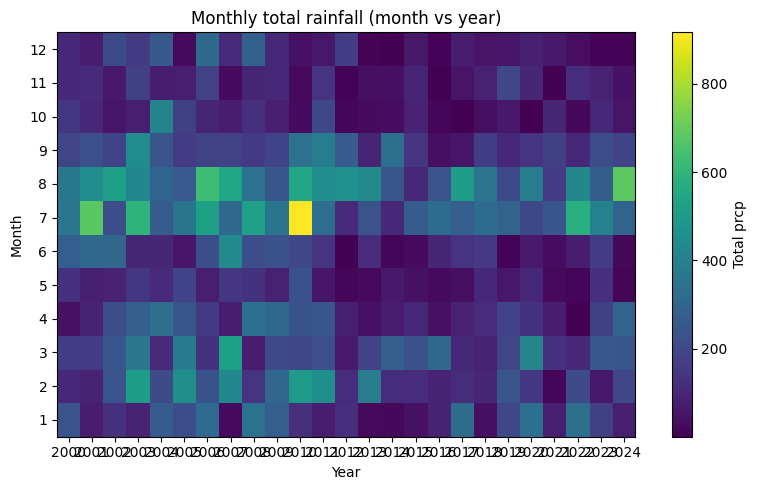

In [9]:
# Rainfall heatmap (sum of prcp)
pivot = df.pivot_table(index='month', columns='year', values='prcp', aggfunc='sum')
plt.figure(figsize=(8,5))
plt.imshow(pivot, aspect='auto', origin='lower')
plt.colorbar(label='Total prcp')
plt.yticks(np.arange(0,12), np.arange(1,13))
plt.xticks(np.arange(len(pivot.columns)), pivot.columns)
plt.title('Monthly total rainfall (month vs year)')
plt.xlabel('Year')
plt.ylabel('Month')
plt.tight_layout()
plt.show()


#### Visualization E — Correlation Between Weather Variables

We calculate correlations between numeric variables (`tavg`, `tmin`, `tmax`, `humidity`, `pressure`, etc.).

- Correlation values range from **-1 (strong negative)** to **+1 (strong positive)**.
- A heatmap helps visualize which variables move together.

**Important:**
- Confirms expected relationships (e.g., `tavg` should correlate strongly with `tmin` and `tmax`).
- Helps identify redundant features (useful for modeling).


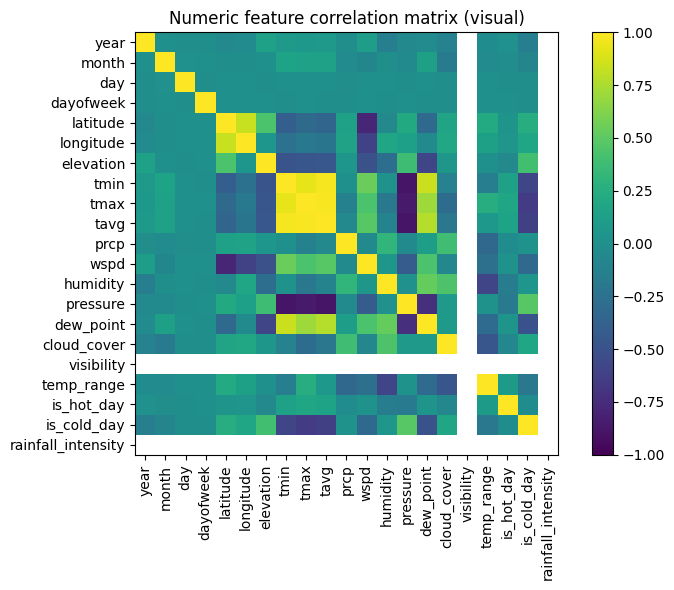

In [10]:
num = df.select_dtypes(include='number')
corr = num.corr()
plt.figure(figsize=(8,6))
plt.imshow(corr, vmin=-1, vmax=1)
plt.colorbar()
plt.xticks(range(len(corr)), corr.columns, rotation=90)
plt.yticks(range(len(corr)), corr.columns)
plt.title('Numeric feature correlation matrix (visual)')
plt.tight_layout()
plt.show()


#### Visualization F — Relationship Between Temperature and Humidity

We create a scatterplot of **temperature (`tavg`) vs humidity**:

- Each point is a daily observation.
- A trend line is added to see the overall direction of the relationship.

**Why it is important:**
- Shows whether higher humidity is associated with cooler or warmer days.
- Useful for understanding comfort levels and extreme weather (e.g., hot + humid conditions).


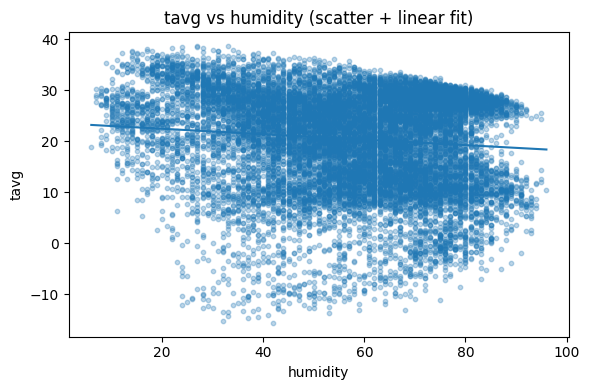

In [11]:
# Scatter + linear fit (sample)
sample = df.dropna(subset=['tavg','humidity']).sample(frac=0.5, random_state=1)
x = sample['humidity']
y = sample['tavg']
coef = np.polyfit(x, y, 1)
poly = np.poly1d(coef)

plt.figure(figsize=(6,4))
plt.scatter(x, y, s=10, alpha=0.3)
plt.plot(np.sort(x), poly(np.sort(x)))
plt.xlabel('humidity')
plt.ylabel('tavg')
plt.title('tavg vs humidity (scatter + linear fit)')
plt.tight_layout()
plt.show()


#### Detecting Outliers in Temperature

Outliers are values that are unusually high or low compared to the rest of the data.  
We use the **Interquartile Range (IQR) method**:

- Define the lower bound = Q1 − 1.5 × IQR.  
- Define the upper bound = Q3 + 1.5 × IQR.  
- Any values outside this range are considered potential outliers.

**Why do it:**
- Outliers could represent **extreme weather events** (e.g., heatwaves, cold snaps).
- Or there may be **data errors** (e.g., faulty sensor readings).


In [12]:
# IQR-based outliers for tavg
q1 = df['tavg'].quantile(0.25)
q3 = df['tavg'].quantile(0.75)
iqr = q3 - q1
lower = q1 - 1.5*iqr
upper = q3 + 1.5*iqr
outliers = df[(df['tavg'] < lower) | (df['tavg'] > upper)]
print("Outlier count (tavg):", outliers.shape[0])
display(outliers.head())


Outlier count (tavg): 246


,date,year,month,day,dayofweek,is_weekend,season,city,region,latitude,longitude,elevation,tmin,tmax,tavg,prcp,wspd,humidity,pressure,dew_point,cloud_cover,visibility,temp_range,is_hot_day,is_cold_day,rainfall_intensity,wind_category
67,2000-01-17,2000,1,17,0,False,Winter,Gilgit,Gilgit-Baltistan,35.9221,74.3087,1500,-14.2,-7.9,-10.8,0.0,2.6,53,1039.2,-18.6,68,NaN,6.3,0,1,NaN,breezy
81,2000-01-21,2000,1,21,4,False,Winter,Gilgit,Gilgit-Baltistan,35.9221,74.3087,1500,-11.8,-7.4,-9.8,0.0,2.6,52,1025.6,-17.9,36,NaN,4.4,0,1,NaN,breezy
89,2000-01-23,2000,1,23,6,True,Winter,Gilgit,Gilgit-Baltistan,35.9221,74.3087,1500,-11.2,-6.5,-9.4,0.0,2.6,60,1032.5,-15.9,64,NaN,4.7,0,1,NaN,breezy
95,2000-01-24,2000,1,24,0,False,Winter,Gilgit,Gilgit-Baltistan,35.9221,74.3087,1500,-11.7,-6.9,-9.4,0.8,2.8,58,1034.7,-16.1,82,NaN,4.8,0,1,NaN,breezy
110,2000-01-28,2000,1,28,4,False,Winter,Gilgit,Gilgit-Baltistan,35.9221,74.3087,1500,-15.7,-7.2,-11.3,0.0,3.1,64,1039.8,-17.1,27,NaN,8.5,0,1,NaN,breezy


#### Baseline Predictive Modeling

A simple **predictive model**:

- Target variable: **average daily temperature (`tavg`)**.
- Features: `tmin`, `tmax`, `prcp`, `humidity`, `pressure`, `dew_point`, and city/month.
- Model: **Random Forest Regressor** (nonlinear, handles missing values reasonably well).

We train the model on part of the dataset and test it on unseen data.

**Metrics:**
- **MAE (Mean Absolute Error):** average size of prediction errors.
- **RMSE (Root Mean Squared Error):** penalizes larger mistakes more heavily.

This provides a baseline — not the most advanced forecast, but shows that weather data has predictive power.


In [13]:
# Baseline ML: predict tavg using simple features (city encoded, month, wsdp, prcp...)
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Prepare dataset (drop rows with missing target)
df_model = df.dropna(subset=['tavg']).copy()

# Basic features
df_model['month'] = df_model['date'].dt.month
features = ['month','tmin','tmax','prcp','wspd','humidity','pressure','dew_point']
# encode city using one-hot (only cities with enough data)
df_model = pd.get_dummies(df_model, columns=['city'], drop_first=True)

# keep features that exist
features = [f for f in features if f in df_model.columns]
X = df_model[features + [c for c in df_model.columns if c.startswith('city_')]]
y = df_model['tavg'].astype(float)

# train/test split by time (recommended) - here simple random split for baseline
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
model.fit(X_train, y_train)
pred = model.predict(X_test)

mae = mean_absolute_error(y_test, pred)
mse = mean_squared_error(y_test, pred)
rmse = np.sqrt(mse)

print("MAE:", mae, "RMSE:", rmse)


MAE: 0.2889482378854625 RMSE: 0.3837225972283396


## Conclusions & Insights

From the analysis we can highlight:

1. **Seasonality:** Temperatures follow a strong annual cycle with clear summer/winter differences.
2. **Rainfall:** Monsoon dominates July–September, with significant year-to-year variation.
3. **Regional differences:** Cities show distinct temperature distributions depending on geography.
4. **Correlations:** Expected relationships confirmed (tmin/tmax vs tavg, humidity inverse relation).
5. **Predictive modeling:** Even a simple model explains much of the variation in daily temperature.
